# Soft Sorting

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import functools
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

import ott

## Sorting operators

Given an array of $n$ numbers, several operators arise around the idea of sorting:

- The `sort` operator reshuffles the values in order, from smallest to largest.
- The `rank` operator associates to each value its rank, when sorting in ascending order.
- The `quantile` operator consider a `level` value between 0 and 1, to return the element of the sorted array indexed at `int(n * level)`, the median for instance if that level is set to $0.5$.
- The `topk` operator is equivalent to the `sort` operator, but only returns the
largest $k$ values, namely the last $k$ values of the sorted vector.

Here are some examples

In [ ]:
x = jnp.array([1.0, 5.0, 4.0, 8.0, 12.0])
jnp.sort(x)

DeviceArray([ 1.,  4.,  5.,  8., 12.], dtype=float32)

In [ ]:
def rank(x):
    return jnp.argsort(jnp.argsort(x))


rank(x)

DeviceArray([0, 2, 1, 3, 4], dtype=int32)

In [ ]:
jnp.quantile(x, 0.5)

DeviceArray(5., dtype=float32)

## Soft operators

Sorting operators are ubiquitous in CS and stats, but have several limitations when used in modern deep learning architectures. For instance, `ranks` is integer valued: if used at some point within a DL pipeline, one won't be able to differentiate through that step because the gradient of these integer values does not exist, or is ill-defined. Indeed, the vector of `ranks` of a slightly perturbed vector $x+\Delta x$ is the same as that for $x$, or switches ranks at some indices when inversions occur. Practially speaking, any loss or intermediary operation based on `ranks` will break backpropagation.

This colab shows how _soft_ counterparts to these operators are defined in OTT. By _soft_, we mean **differentiable**, **approximate** proxies to these original _"hard"_ operators. For instance `soft_sort.ranks` returned by OTT operators won't be integer valued, but instead floating point approximations; `soft_sort.sort` will not contain exactly the `n` values contained in the input array, reordered, but instead `n` combinaisons of thoses values that look very close to them.

**These soft operators trade off accuracy for a more informative Jacobian**. This trade-off is controlled by a non-negative parameter `epsilon`: The *smaller* `epsilon`, the closer to the original ranking and sorting operations; The *bigger*, the more bias yet the more informative gradients. That `epsilon` also correponds to that used in regularized OT (see doc on [sinkhorn](https://ott-jax.readthedocs.io/en/latest/_autosummary/ott.core.sinkhorn.sinkhorn.html#ott.core.sinkhorn.sinkhorn)).

The behavior of these operators is illustrated below.

### Soft sort

In [ ]:
softsort = jax.jit(ott.tools.soft_sort.sort)
print(softsort(x))

[ 1.0504128  4.1227636  4.8619957  8.006992  11.958238 ]


As we can see, the values are close to the original ones but not exactly equal. Here, `epsilon` is set by default to `1e-2`. A smaller `epsilon` reduces that gap, whereas a bigger one would tend to squash all returned values to the **average** of the input values.

In [ ]:
print(softsort(x, epsilon=1e-4))
print(softsort(x, epsilon=1e-1))

[ 0.99836105  3.9950502   5.0066338   8.009814   11.990994  ]
[ 2.5705311  3.7338936  5.462167   8.000687  10.233383 ]


### Soft topk

The soft operators we propose build on a common idea: formulate sorting operations as optimal transports from an array of $n$ values to a predefined target measure of $m$ points. The user is free to choose $m$, providing great flexibility depending on the use case. 

Transporting an input discrete measure of $n$ points towards one of $m$ points results in a $O(nm)$ complexity. The bigger $m$, the more fine grained quantities we recover. For instance, if we wish to get both a fine grained yet differentiable sorted vector, or vector of ranks, one can define a target measure of size $m=n$, leading to a $O(n^2)$ complexity.

On the contrary, if we are only interested in singling out a few important ranks, such as when considering `top k` values, we can simply transport the inputs points onto $k+1$ targets, leading to a smaller complexity in $O(nk)$. When $k \ll n$, the gain in time and memory can be of course substantial.

Here is an example.

In [ ]:
top5 = jax.jit(functools.partial(ott.tools.soft_sort.sort, topk=5))

# Generates a vector of size 1000
big_x = jax.random.uniform(jax.random.PRNGKey(0), (1000,))
top5(big_x)

DeviceArray([0.95064366, 0.974145  , 0.98327726, 0.9879082 , 0.99055624],            dtype=float32)

### Soft Ranks

Similarly, we can compute soft ranks, which do not output integer values, but provide instead a differentiable, float valued, approximation of the vector of ranks.

In [ ]:
softranks = jax.jit(ott.tools.soft_sort.ranks)
print(softranks(x))

[0.01550194 1.8386561  1.1487608  2.9977381  3.9927583 ]


### Regularization effect
As mentioned earlier, `epsilon` controls the tradeoff between accuracy and differentiability. Larger `epsilon` tend to merge the _soft_ ranks of values that are close, up to the point where they all collapse to the average rank or agverage value.


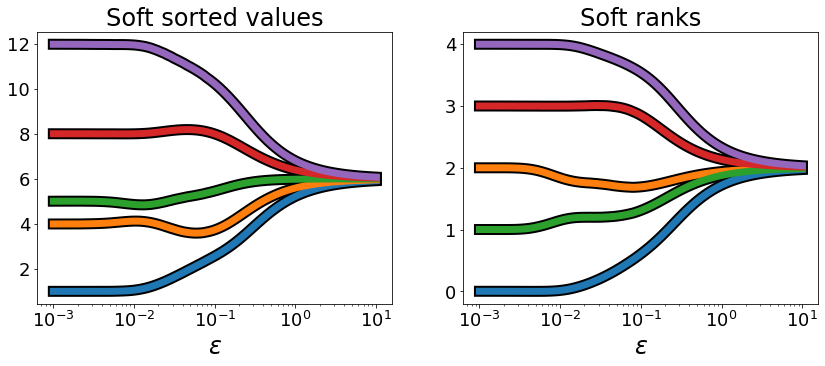

In [ ]:
epsilons = np.logspace(-3, 1, 100)
sorted_values = []
ranks = []
for e in epsilons:
    sorted_values.append(softsort(x, epsilon=e))
    ranks.append(softranks(x, epsilon=e))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for values, ax, title in zip(
    (sorted_values, ranks), axes, ("sorted values", "ranks")
):
    ax.plot(epsilons, np.array(values), color="k", lw=11)
    ax.plot(epsilons, np.array(values), lw=7)
    ax.set_xlabel("$\epsilon$", fontsize=24)
    ax.tick_params(axis="both", which="both", labelsize=18)
    ax.set_title(f"Soft {title}", fontsize=24)
    ax.set_xscale("log")

Note how none of the lines above cross. This is a fundamental property of `soft-sort` operators, proved in <cite data-cite="cuturi:20a">Cuturi et al.</cite>: soft sorting and ranking operators are monotonic: the vector of soft-sorted values will remain increasing for any `epsilon`, whereas if an input value $x_i$ has a smaller (hard) rank than $x_j$, its soft-rank, for any value of `epsilon`, will also remain smaller than that for $x_j$.

### Soft quantile

To illustrate further the flexibility provided by setting target measures, one can notice that when a soft quantile is targeted (for instance the soft median), the complexity becomes simply $O(n)$. This is illustrated below to define "soft median" differentiable filter on a noisy image.

In [ ]:
softquantile = jax.jit(ott.tools.soft_sort.quantile)
softquantile(x, level=0.5)

DeviceArray([4.995768], dtype=float32)

In [ ]:
import io
import requests

url = "https://raw.githubusercontent.com/matplotlib/matplotlib/master/doc/_static/stinkbug.png"
resp = requests.get(url)
image = plt.imread(io.BytesIO(resp.content))
image = image[..., 0]

In [ ]:
def salt_and_pepper(im, amount=0.05):
    result = np.copy(im)
    result = np.reshape(result, (-1,))
    num_noises = int(np.ceil(amount * im.size))
    indices = np.random.randint(0, im.size, num_noises)
    values = np.random.uniform(size=(num_noises,)) > 0.5
    result[indices] = values
    return np.reshape(result, im.shape)


noisy_image = salt_and_pepper(image, amount=0.1)

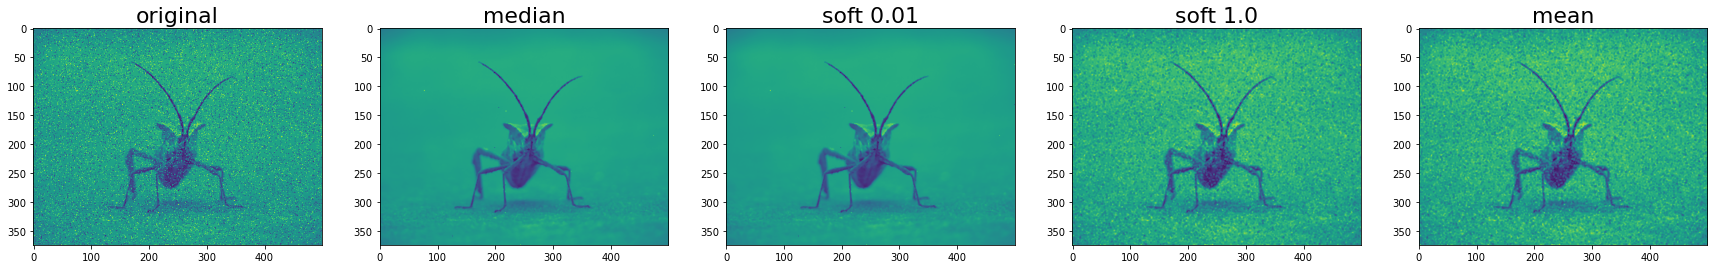

In [ ]:
softmedian = jax.jit(functools.partial(ott.tools.soft_sort.quantile, level=0.5))

fns = {"original": None, "median": np.median}
for e in [0.01, 1.0]:
    fns[f"soft {e}"] = functools.partial(softmedian, epsilon=e)
fns.update(mean=np.mean)

fig, axes = plt.subplots(1, len(fns), figsize=(len(fns) * 6, 4))
for key, ax in zip(fns, axes):
    fn = fns[key]
    soft_denoised = (
        scipy.ndimage.generic_filter(noisy_image, fn, size=(3, 3))
        if fn is not None
        else noisy_image
    )
    ax.imshow(soft_denoised)
    ax.set_title(key, fontsize=22)

## Learning through a soft ranks operator.

A crucial feature of OTT lies in the ability it provides to **differentiate** seamlessly through any quantities that follow an optimal transport computation, making it very easy for end-users to plug them directly into end-to-end differentiable architectures. 

In this tutorial we show how OTT can be used to implement a loss based on soft ranks. That soft 0-1 loss is used here to train a neural network for image classification, as done by <cite data-cite="cuturi:19">Cuturi et al.</cite>

This implementation relies on [FLAX](https://github.com/google/flax) a neural network library for JAX.

### Model

Similarly to <cite data-cite="cuturi:19">Cuturi et al.</cite>, we will train a vanilla CNN made of 4 convolutional blocks, in order to classify images from the CIFAR-10 dataset.

In [ ]:
from typing import Any
import flax
from flax import linen as nn


class ConvBlock(nn.Module):
    """A simple CNN block."""

    features: int = 32
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x


class CNN(nn.Module):
    """A simple CNN model."""

    num_classes: int = 10
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = ConvBlock(features=32)(x)
        x = ConvBlock(features=64)(x)
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

### Losses & Metrics

The $0/1$ loss of a classifier on a labeled example is $0$ if the logit of the true class ranks on top (here, would have rank 9, since CIFAR-10 considers 10 classes). Of course the $0/1$ loss is non-differentiable, which is why the cross-entropy loss is used instead.

Here, as in <cite data-cite="cuturi:19">Cuturi et al.</cite>, we consider a differentiable "soft" 0/1 loss by measuring the gap between the soft-rank of the logit of the right answer and the target rank, 9. If that gap is bigger than 0, then we incurr a loss equal to that gap.

In [ ]:
def cross_entropy_loss(logits, labels):
    logits = nn.log_softmax(logits)
    return -jnp.sum(labels * logits) / labels.shape[0]


def soft_error_loss(logits, labels):
    """The average distance between the best rank and the rank of the true class."""
    ranks_fn = jax.jit(functools.partial(ott.tools.soft_sort.ranks, axis=-1))
    soft_ranks = ranks_fn(logits)
    return jnp.mean(
        nn.relu(labels.shape[-1] - 1 - jnp.sum(labels * soft_ranks, axis=1))
    )

To know more about training a neural network with Flax, please refer to the [Flax Imagenet examples](https://github.com/google/flax/tree/master/examples/imagenet/). After 100 epochs through the CIFAR-10 training examples, we are able to reproduce the results from <cite data-cite="cuturi:19">Cuturi et al.</cite> and see that a soft $0/1$ error loss, building on top of `soft_sort.ranks`, can provide a competitive alternative to the cross entropy loss for classification tasks. As mentioned in that paper, that loss is less prone to overfitting. 

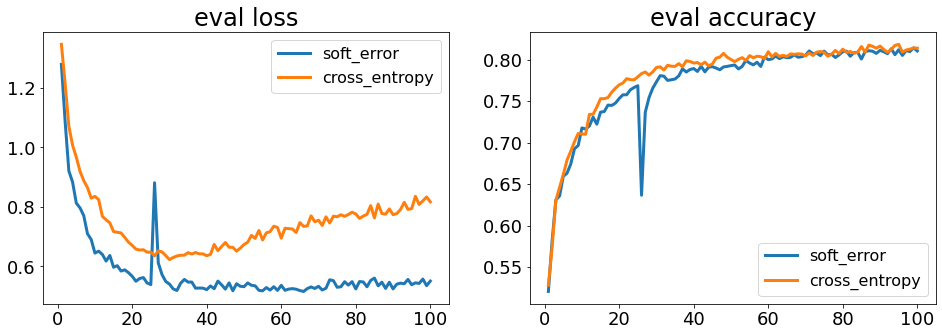

In [ ]:
# Plot results from training